# Definitions

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
data_path = Path('.', 'data')

In [3]:
RANDOM_STATE = 648

In [4]:
target_name = 'dep_delayed_15min'

# Data

In [5]:
train = pd.read_csv(data_path.joinpath('flight_delays_train.csv'))
test = pd.read_csv(data_path.joinpath('flight_delays_test.csv'))

In [6]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [7]:
train[target_name] = train[target_name].map({"Y": 1, "N": 0})

In [8]:
train[target_name].mean()

0.19044

In [9]:
train[target_name][train.DepTime > 2400].mean()

1.0

In [10]:
train[target_name][train.DepTime > 2400].shape

(17,)

In [11]:
train.shape

(100000, 9)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


In [13]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [14]:
test.shape

(100000, 8)

## Split Data

In [15]:
X, y = train.drop(target_name, axis=1), train[target_name]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Preproc

## Exploration

<AxesSubplot:>

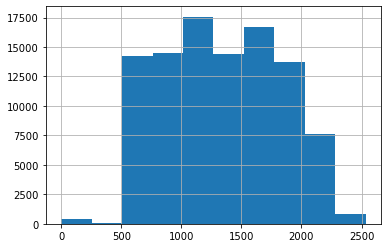

In [17]:
train.DepTime.hist()

In [18]:
train.DepTime.min(), train.DepTime.max()

(1, 2534)

In [19]:
time_groups = train.groupby((train.DepTime-1) // 100) 

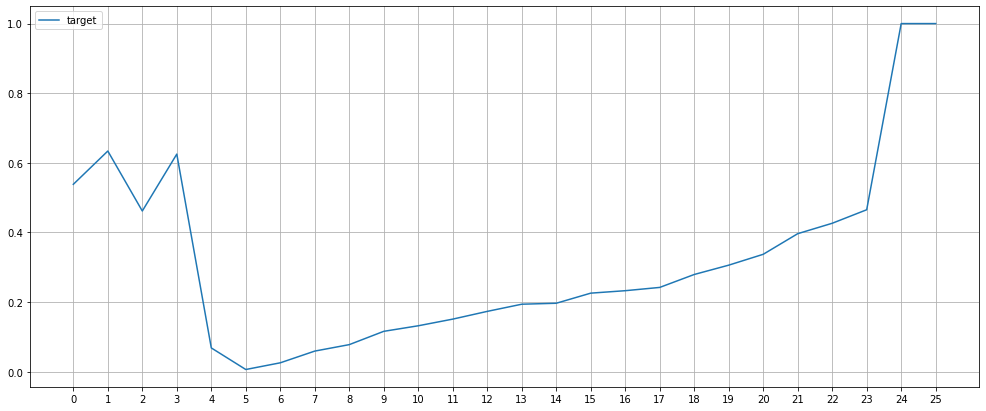

In [20]:
mean_by_t = time_groups[target_name].mean()
count_by_t = time_groups[target_name].count()

plt.figure(figsize=(17, 7))

plt.plot(mean_by_t.index, mean_by_t, label='target')
plt.xticks(range(0, 26))
plt.grid()
plt.legend()

## timestamp decoding

In [21]:
def get_ts(df):
    df['hour'] = df.DepTime // 100
    df['minute'] = df.DepTime % 100
    df['d_month'] = df.DayofMonth.str[2:].astype(int)
    df['d_week'] = df.DayOfWeek.str[2:].astype(int)
    df['month'] = df.Month.str[2:].astype(int)
    
    return df

## timestamp encoding

In [22]:
X = get_ts(X)

In [23]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,d_month,d_week,month
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,19,34,21,7,8
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,15,48,20,3,4
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,14,22,2,5,9
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,10,15,25,6,11
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,18,28,7,6,10


In [24]:
'2021-' + X.month.astype(str) + '-' + X.d_month.astype(str).str.zfill(2) + '-' + X.hour.astype(str).str.zfill(2) + '-' + X.minute.astype(str).str.zfill(2) + '-00'

0         2021-8-21-19-34-00
1         2021-4-20-15-48-00
2         2021-9-02-14-22-00
3        2021-11-25-10-15-00
4        2021-10-07-18-28-00
                ...         
99995     2021-5-04-16-18-00
99996     2021-1-18-08-04-00
99997     2021-1-24-19-01-00
99998     2021-4-27-15-15-00
99999    2021-11-17-18-00-00
Length: 100000, dtype: object

In [25]:
X_ = X[X.DepTime < 2400]
train['dep_dt'] = pd.to_datetime('2021-' + \
                             X_.month.astype(str).str.zfill(2) + '-' +
                             X_.d_month.astype(str).str.zfill(2) + '-' +
                             X_.hour.astype(str).str.zfill(2) + '-' +
                             X_.minute.astype(str).str.zfill(2) + '-00',
                             format='%Y-%m-%d-%H-%M-%S')

<AxesSubplot:>

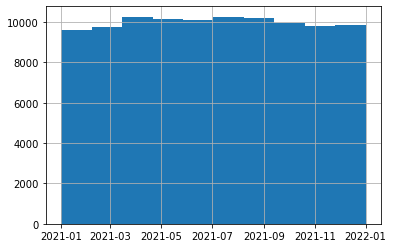

In [26]:
train.dep_dt.hist()

<AxesSubplot:xlabel='dep_dt'>

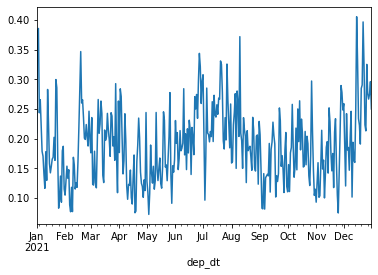

In [27]:
train.groupby(train.dep_dt.dt.to_period('d'))[target_name].mean().plot()

<AxesSubplot:xlabel='dep_dt'>

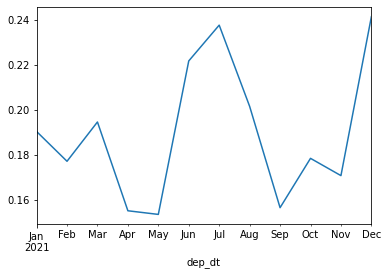

In [28]:
train.groupby(train.dep_dt.dt.to_period('M'))[target_name].mean().plot()

In [29]:
def ts_features(df):
    X_ = df[df.DepTime < 2400]
    dep_dt = pd.to_datetime('2021-' +
                                  X_.month.astype(str).str.zfill(2) + '-' +
                                  X_.d_month.astype(str).str.zfill(2) + '-' +
                                  X_.hour.astype(str).str.zfill(2) + '-' +
                                  X_.minute.astype(str).str.zfill(2) + '-00',
                                  format='%Y-%m-%d-%H-%M-%S')
    dep_td = dep_dt - pd.to_datetime('2021-01-01')
    df['days_since_ny'] = dep_td.dt.days
    df['secs_since_ny'] = dep_td.dt.seconds
    
    return df

## Category encoding

In [30]:
cat_cols = X_train.select_dtypes(include=[object, 'category']).columns

In [31]:
cat_cols

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')

In [32]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [33]:
%%time
enc.fit(X_train[cat_cols])
print('Done')

Done
CPU times: user 116 ms, sys: 13 ms, total: 129 ms
Wall time: 129 ms


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Sin/cos ts processing

In [34]:
t_limits = {'minute': (0, 59),
             'hour': (0, 23),
             'd_week': (1, 7),
             'd_month': (1, 31),
             'month': (1, 12),
             'days_since_ny': (0, 364)}

In [35]:
def sin_cos(df):
    for col_name, limits in t_limits.items():
        max_val = limits[1]
        min_val = limits[0]
        if col_name == 'hour':
            orig_vals = df[col_name].clip(upper=max_val)
        else:
            orig_vals = df[col_name]
        df[col_name + '_sin'] = np.sin(2*np.pi/(max_val - min_val)*orig_vals)
        df[col_name + '_cos'] = np.cos(2*np.pi/(max_val - min_val)*orig_vals)
        
    return df

## Sum up prepocessing

In [36]:
def preproc(df):
    df = get_ts(df)
    df = ts_features(df)
    df = sin_cos(df)
    
    df[cat_cols] = enc.transform(df[cat_cols])
    df[cat_cols] = df[cat_cols].astype('category')
    
    # Special features
    df['after_midnight'] = 0
    df.loc[df.DepTime > 2400, 'after_midnight'] = 1
    
    return df

In [37]:
%%time
X_train = preproc(X_train)
X_test = preproc(X_test)

<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

CPU times: user 1.46 s, sys: 127 ms, total: 1.59 s
Wall time: 1.7 s


<ipython-input-29-6ca10571684d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_since_ny'] = dep_td.dt.days
<ipython-input-29-6ca10571684d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['secs_since_ny'] = dep_td.dt.seconds
<ipython-input-35-02630819fc8c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

# Fit

In [38]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,...,hour_cos,d_week_sin,d_week_cos,d_month_sin,d_month_cos,month_sin,month_cos,days_since_ny_sin,days_since_ny_cos,after_midnight
46343,1.0,1.0,1.0,1805,1.0,1.0,1.0,1235,18,5,...,0.203456,8.660254e-01,0.5,-9.945219e-01,-0.104528,-9.898214e-01,-0.142315,-0.770953,-0.636892,0
75701,2.0,2.0,2.0,819,2.0,2.0,2.0,892,8,19,...,-0.576680,1.224647e-16,-1.0,1.224647e-16,-1.000000,9.096320e-01,0.415415,0.700978,0.713183,0
89227,3.0,3.0,2.0,726,3.0,3.0,3.0,200,7,26,...,-0.334880,1.224647e-16,-1.0,-5.877853e-01,-0.809017,-5.406408e-01,0.841254,-0.957253,0.289252,0
70825,4.0,4.0,3.0,1515,1.0,4.0,4.0,403,15,15,...,-0.576680,8.660254e-01,0.5,8.660254e-01,-0.500000,7.557496e-01,-0.654861,0.990480,-0.137654,0
26022,5.0,5.0,4.0,1453,4.0,5.0,5.0,94,14,53,...,-0.775711,-8.660254e-01,0.5,-9.510565e-01,0.309017,-2.449294e-16,1.000000,-0.596132,0.802886,0


In [39]:
model = lgb.LGBMClassifier()

In [40]:
lgbm_params = {'boosting': 'gbdt',
               'bagging_freq': 1,
               'n_estimators': 434,
               'random_state': RANDOM_STATE,
               'silent': False,
               'bagging_fraction': 0.638782643397927,
               'feature_fraction': 0.5072049472753989,
               'learning_rate': 0.02238858415024258,
               'max_depth': 10,
               'min_data_in_leaf': 7,
               'reg_alpha': 4.16689412832005,
               'reg_lambda': 3.0220290348080594,
               'n_jobs': 4}

In [41]:
model.set_params(**lgbm_params)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='gbdt',
               feature_fraction=0.8, max_depth=10, min_data_in_leaf=700,
               n_estimators=10000, n_jobs=8, random_state=648, reg_alpha=5,
               reg_lambda=5)

In [42]:
X_tr, X_es, y_tr, y_es = train_test_split(X_train, y_train,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [43]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          early_stopping_rounds=100)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	training's auc: 0.716656	training's binary_logloss: 0.479923	valid_1's auc: 0.692579	valid_1's binary_logloss: 0.478211
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.727056	training's binary_logloss: 0.472899	valid_1's auc: 0.70214	valid_1's binary_logloss: 0.472052
[3]	training's auc: 0.731033	training's binary_logloss: 0.466707	valid_1's auc: 0.707762	valid_1's binary_logloss: 0.466567
[4]	training's auc: 0.734859	training's binary_logloss: 0.461411	valid_1's auc: 0.711258	valid_1's binary_logloss: 0.461988
[5]	training's auc: 0.738869	training's binary_logloss: 0.456748	valid_1's auc: 0.715236	valid_1's binary_logloss: 0.458031
[6]	training's auc: 0.741034	training's binary_logloss: 0.452957	valid_1's auc: 0.717001	valid_1's binary_logloss: 0.454768
[7]	training's auc: 0.74334	training's binary_logloss: 0.449328	valid_1's auc: 0.718686	valid_1's binary_logloss: 0.451857
[8]	training's auc: 0.744321	training's binary_logloss: 0.446368	valid_1

[71]	training's auc: 0.832122	training's binary_logloss: 0.378642	valid_1's auc: 0.732174	valid_1's binary_logloss: 0.429351
[72]	training's auc: 0.833259	training's binary_logloss: 0.378004	valid_1's auc: 0.732102	valid_1's binary_logloss: 0.429434
[73]	training's auc: 0.833908	training's binary_logloss: 0.377608	valid_1's auc: 0.731819	valid_1's binary_logloss: 0.429548
[74]	training's auc: 0.834836	training's binary_logloss: 0.377006	valid_1's auc: 0.732212	valid_1's binary_logloss: 0.429389
[75]	training's auc: 0.835773	training's binary_logloss: 0.376426	valid_1's auc: 0.731772	valid_1's binary_logloss: 0.42958
[76]	training's auc: 0.836642	training's binary_logloss: 0.375872	valid_1's auc: 0.731684	valid_1's binary_logloss: 0.429658
[77]	training's auc: 0.837072	training's binary_logloss: 0.375429	valid_1's auc: 0.731943	valid_1's binary_logloss: 0.429507
[78]	training's auc: 0.83758	training's binary_logloss: 0.374928	valid_1's auc: 0.732305	valid_1's binary_logloss: 0.429316
[7

[139]	training's auc: 0.873507	training's binary_logloss: 0.34821	valid_1's auc: 0.732078	valid_1's binary_logloss: 0.430061
[140]	training's auc: 0.873671	training's binary_logloss: 0.348008	valid_1's auc: 0.731776	valid_1's binary_logloss: 0.430282
[141]	training's auc: 0.874025	training's binary_logloss: 0.347694	valid_1's auc: 0.731584	valid_1's binary_logloss: 0.430429
[142]	training's auc: 0.874436	training's binary_logloss: 0.347367	valid_1's auc: 0.731503	valid_1's binary_logloss: 0.430485
[143]	training's auc: 0.875096	training's binary_logloss: 0.346897	valid_1's auc: 0.731363	valid_1's binary_logloss: 0.430563
[144]	training's auc: 0.875562	training's binary_logloss: 0.346501	valid_1's auc: 0.731115	valid_1's binary_logloss: 0.430736
[145]	training's auc: 0.876011	training's binary_logloss: 0.346163	valid_1's auc: 0.730869	valid_1's binary_logloss: 0.430841
[146]	training's auc: 0.876477	training's binary_logloss: 0.345778	valid_1's auc: 0.731127	valid_1's binary_logloss: 0.

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='gbdt',
               feature_fraction=0.8, max_depth=10, min_data_in_leaf=700,
               n_estimators=10000, n_jobs=8, random_state=648, reg_alpha=5,
               reg_lambda=5)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

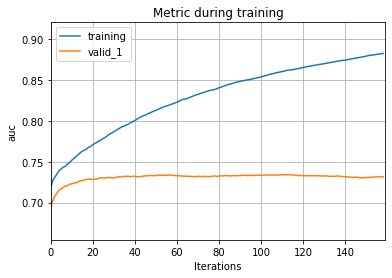

In [44]:
lgb.plot_metric(model, metric='auc')

In [45]:
fi = pd.Series(model.feature_importances_, index=X_tr.columns)

In [46]:
with pd.option_context('display.max_rows', None):
    display(fi.sort_values(ascending=False))

Dest                 483
Origin               428
DayofMonth           312
UniqueCarrier        116
Month                 90
DepTime               57
hour_sin              50
days_since_ny_sin     32
DayOfWeek             31
secs_since_ny         26
hour_cos              26
days_since_ny_cos     24
days_since_ny         22
minute_cos            15
d_week_sin            15
Distance              10
minute_sin             9
d_week                 6
minute                 5
d_month                4
d_month_sin            2
hour                   1
d_week_cos             1
month_sin              1
month                  0
d_month_cos            0
month_cos              0
after_midnight         0
dtype: int32

# Validate

In [47]:
def get_proba(X):
    proba = model.predict_proba(X)[:, 1]
#     proba[X.DepTime > 2400] = 1.
    return proba

In [48]:
tr_proba = get_proba(X_tr)

In [49]:
roc_auc_score(y_tr, get_proba(X_tr))

0.8205988962071462

In [50]:
roc_auc_score(y_train, get_proba(X_train))

0.8120673490637935

In [51]:
roc_auc_score(y_test, get_proba(X_test))

0.7332721993239084

# Commit

## Refit on full dataset

In [52]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [53]:
enc.fit(X_train[cat_cols]);

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [54]:
X = preproc(X)

In [55]:
X_tr, X_es, y_tr, y_es = train_test_split(X, y,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [56]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          early_stopping_rounds=100)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	training's auc: 0.703325	training's binary_logloss: 0.478792	valid_1's auc: 0.693929	valid_1's binary_logloss: 0.482672
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.705605	training's binary_logloss: 0.472592	valid_1's auc: 0.696824	valid_1's binary_logloss: 0.47674
[3]	training's auc: 0.707542	training's binary_logloss: 0.467474	valid_1's auc: 0.69737	valid_1's binary_logloss: 0.47196
[4]	training's auc: 0.710773	training's binary_logloss: 0.463213	valid_1's auc: 0.701339	valid_1's binary_logloss: 0.467773
[5]	training's auc: 0.712096	training's binary_logloss: 0.459561	valid_1's auc: 0.702638	valid_1's binary_logloss: 0.464323
[6]	training's auc: 0.713356	training's binary_logloss: 0.456481	valid_1's auc: 0.704497	valid_1's binary_logloss: 0.46137
[7]	training's auc: 0.714437	training's binary_logloss: 0.453667	valid_1's auc: 0.706034	valid_1's binary_logloss: 0.458633
[8]	training's auc: 0.715066	training's binary_logloss: 0.451316	valid_1's

[69]	training's auc: 0.741733	training's binary_logloss: 0.425638	valid_1's auc: 0.722639	valid_1's binary_logloss: 0.437506
[70]	training's auc: 0.741983	training's binary_logloss: 0.425484	valid_1's auc: 0.722484	valid_1's binary_logloss: 0.437518
[71]	training's auc: 0.742287	training's binary_logloss: 0.425332	valid_1's auc: 0.722634	valid_1's binary_logloss: 0.437453
[72]	training's auc: 0.742602	training's binary_logloss: 0.4252	valid_1's auc: 0.722401	valid_1's binary_logloss: 0.43752
[73]	training's auc: 0.742863	training's binary_logloss: 0.425073	valid_1's auc: 0.722443	valid_1's binary_logloss: 0.437534
[74]	training's auc: 0.743118	training's binary_logloss: 0.424943	valid_1's auc: 0.722604	valid_1's binary_logloss: 0.437462
[75]	training's auc: 0.743349	training's binary_logloss: 0.424809	valid_1's auc: 0.722633	valid_1's binary_logloss: 0.437383
[76]	training's auc: 0.743512	training's binary_logloss: 0.424709	valid_1's auc: 0.722595	valid_1's binary_logloss: 0.437345
[77

[139]	training's auc: 0.756461	training's binary_logloss: 0.417647	valid_1's auc: 0.722965	valid_1's binary_logloss: 0.436653
[140]	training's auc: 0.756668	training's binary_logloss: 0.417558	valid_1's auc: 0.722965	valid_1's binary_logloss: 0.436652
[141]	training's auc: 0.756911	training's binary_logloss: 0.417424	valid_1's auc: 0.72303	valid_1's binary_logloss: 0.43662
[142]	training's auc: 0.757105	training's binary_logloss: 0.417332	valid_1's auc: 0.723058	valid_1's binary_logloss: 0.436626
[143]	training's auc: 0.757245	training's binary_logloss: 0.417258	valid_1's auc: 0.722991	valid_1's binary_logloss: 0.436652
[144]	training's auc: 0.757439	training's binary_logloss: 0.417161	valid_1's auc: 0.723007	valid_1's binary_logloss: 0.43664
[145]	training's auc: 0.757604	training's binary_logloss: 0.417075	valid_1's auc: 0.722841	valid_1's binary_logloss: 0.436735
[146]	training's auc: 0.757786	training's binary_logloss: 0.416987	valid_1's auc: 0.723009	valid_1's binary_logloss: 0.43

[213]	training's auc: 0.767735	training's binary_logloss: 0.411648	valid_1's auc: 0.722472	valid_1's binary_logloss: 0.436859
[214]	training's auc: 0.767912	training's binary_logloss: 0.411564	valid_1's auc: 0.722355	valid_1's binary_logloss: 0.436899
[215]	training's auc: 0.768072	training's binary_logloss: 0.411488	valid_1's auc: 0.722232	valid_1's binary_logloss: 0.436979
[216]	training's auc: 0.768192	training's binary_logloss: 0.411416	valid_1's auc: 0.722214	valid_1's binary_logloss: 0.43698
[217]	training's auc: 0.768338	training's binary_logloss: 0.411338	valid_1's auc: 0.722222	valid_1's binary_logloss: 0.436983
[218]	training's auc: 0.768516	training's binary_logloss: 0.411257	valid_1's auc: 0.722106	valid_1's binary_logloss: 0.437035
[219]	training's auc: 0.768664	training's binary_logloss: 0.41117	valid_1's auc: 0.722177	valid_1's binary_logloss: 0.437002
[220]	training's auc: 0.768837	training's binary_logloss: 0.411093	valid_1's auc: 0.722169	valid_1's binary_logloss: 0.4

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='gbdt',
               feature_fraction=0.8, max_depth=10, min_data_in_leaf=700,
               n_estimators=10000, n_jobs=8, random_state=648, reg_alpha=5,
               reg_lambda=5)

## Prepare test

In [57]:
test = preproc(test)

In [58]:
test['dep_delayed_15min'] = get_proba(test.drop(target_name,
                                                          axis=1,
                                                          errors='ignore'))

In [59]:
test['dep_delayed_15min'].to_csv(data_path.joinpath('submit.csv'), index_label='id')

# Next Steps

* Grid Search through params
* datetime engineering (sin/cos transform, DepTime limits transform(?))

# Notes

* OHE sucks since model just doesn't use those features
* there are only 1 after 2400

__Best Score__: 0.72193